In [119]:
from glob import glob
import numpy as np
from evFileProcessing import evFuncs # ev COM functions
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from matplotlib.lines import Line2D
import datetime
from pysolar.solar import *
warnings.filterwarnings('ignore')

C11 = 70.0136, -166.85755
C1 = 70.8357, -163.1044
C4 = 71.038916, -160.50353

def addAlt(d,site):
    date = datetime.datetime(d.year, d.month, d.day, d.hour, tzinfo=datetime.timezone.utc)
    return get_altitude(site[0],site[1],date)

def wakeupMWD(df):
    df = df.rename(columns={'datetime':'dt'})
    binCenters = np.arange(2.5,5*df.layer.unique().max(),1)
    depth = []
    #print('appending bin centers...')
    for layer in df.layer:
        depth.append(binCenters[int(layer)-1])
    df['depthBin'] = depth
    df['weightedSA'] = df.sA*df.depthBin
    df = df.groupby(['dt'])[["sA", "weightedSA"]].sum()
    df['mwd'] = df.weightedSA/df.sA
    df = df.reset_index()
    df['solAlt'] = df['dt'].apply(addAlt, site=C11)
    df.set_index('dt')
    df = df.set_index('dt')
    df = df.drop(columns=['weightedSA'])
    return df

def solMinMax(df):
    df = pd.DataFrame({'dt':df[df.index.isin(df.groupby(df.index.date)["solAlt"].idxmax())].index,'day':df[df.index.isin(df.groupby(df.index.date)["solAlt"].idxmax())].mwd.values,'night':df[df.index.isin(df.groupby(df.index.date)["solAlt"].idxmin())].mwd.values})
    df =df.set_index('dt')
    return df

def readCTD(file):
    df = pd.read_csv(file)
    df = df[df.Sal > 20]
    df['dt'] = pd.to_datetime(df['Date']+df['Time'])
    df = df.set_index('dt')
    return df

def readTracks(file):
    dfTracks = pd.read_csv(file)
    dfTracks['Date_S'] = dfTracks['Date_S'].astype(str)
    dfTracks['Datetime'] = pd.to_datetime(dfTracks['Date_S'] + ' ' + dfTracks['Time_S'])
    dfTracks = dfTracks.drop(['Date_S','Time_S'], axis=1)
    dfTracks = dfTracks.set_index('Datetime')
    return dfTracks

In [54]:
# Moorings
filesD1Y1 = glob('../data/2018/EVFiles/DAFT1/exports/1m/70*.csv')
filesD1Y2 = glob('../data/2019/EVFiles/DAFT1/exports/1m/70*.csv')
dfD1 = evFuncs.evExports.readEvExports(filesD1Y1+filesD1Y2)
dfD1 = wakeupMWD(dfD1)
dfD1.name = 'D1'
dfD1_DayNight = solMinMax(dfD1)

filesD2Y1 = glob('../data/2018/EVFiles/DAFT2/exports/1m/70*.csv')
filesD2Y2 = glob('../data/2019/EVFiles/DAFT2/exports/1m/70*.csv')
dfD2 = evFuncs.evExports.readEvExports(filesD2Y1+filesD2Y2)
dfD2 = wakeupMWD(dfD2)
dfD2.name = 'D2'
dfD2_DayNight = solMinMax(dfD2)


filesD3Y2 = glob('../data/2019/EVFiles/DAFT3/exports/1m/70*.csv')
dfD3 = evFuncs.evExports.readEvExports(filesD3Y2)
dfD3 = wakeupMWD(dfD3)
dfD3.name = 'D3'
dfD3_DayNight = solMinMax(dfD3)

In [120]:
# Tracks
df1 = readTracks('../data/analysisFiles/TrackRegions1_linear2.csv')
df4 = readTracks('../data/analysisFiles/TrackRegions4_linear2.csv')
dfD1T = pd.concat([df1,df4])
df2 = readTracks('../data/analysisFiles/TrackRegions2_linear2.csv')
df5 = readTracks('../data/analysisFiles/TrackRegions5_linear2.csv')
dfD2T = pd.concat([df2,df5])
dfD3T = readTracks('../data/analysisFiles/TrackRegions6_linear2.csv')

In [26]:
# CTD
dfCTD1 =readCTD(glob('../data/2018/DAFT1/SBE37/*.csv')[0])
dfCTD4 =readCTD(glob('../data/2019/DAFT1/SBE37/*.csv')[0])
dfD1Ctd = pd.concat([dfCTD1, dfCTD4])
dfCTD2 =readCTD(glob('../data/2018/DAFT2/SBE37/*.csv')[0])
dfCTD5 =readCTD(glob('../data/2019/DAFT2/SBE37/*.csv')[0])
dfD2Ctd = pd.concat([dfCTD2, dfCTD5])
dfD3Ctd =readCTD(glob('../data/2019/DAFT3/SBE37/*.csv')[0])

# Ice
dfD1Ice = pd.read_csv('../data/physicalData/C11_NSIDC.csv',parse_dates=['datetime']).set_index('datetime')
dfD2Ice = pd.read_csv('../data/physicalData/C1_NSIDC.csv',parse_dates=['datetime']).set_index('datetime')
dfD3Ice = pd.read_csv('../data/physicalData/C4_NSIDC.csv',parse_dates=['datetime']).set_index('datetime')

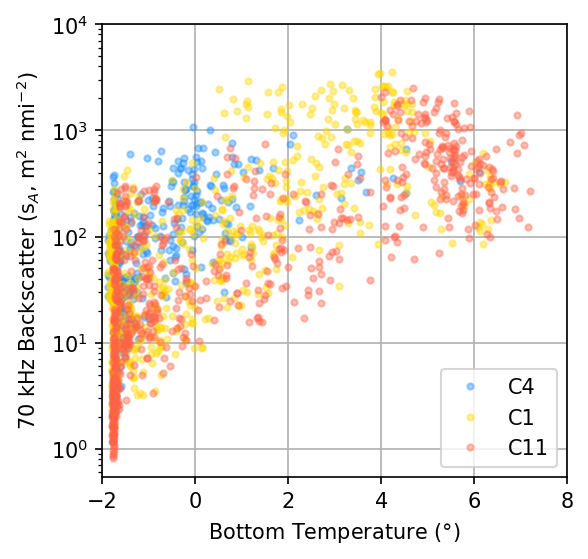

In [27]:
fig = plt.figure(figsize=(4,4),dpi=150)
df = dfD3
a = df['sA'].resample('2H').sum()
b = a.resample('D').mean()
df = dfD3Ctd
a = df.resample('D').mean()
c = a.join(b)
plt.semilogy(c.Temp,c.sA,'.',color='dodgerblue',alpha=0.4)


df = dfD2
a = df['sA'].resample('2H').sum()
b = a.resample('D').mean()
df = dfD2Ctd
a = df.resample('D').mean()
c = a.join(b)
plt.semilogy(c.Temp,(c.sA),'.',color='gold',alpha=0.4)


df = dfD1
a = df['sA'].resample('2H').sum()
b = a.resample('D').mean()
df = dfD1Ctd
a = df.resample('D').mean()
c = a.join(b)
plt.semilogy(c.Temp,(c.sA),'.',color='tomato',alpha=0.4)

plt.axis([-2,8,0,10**4])
plt.grid()
plt.xlabel('Bottom Temperature ($\degree$)')
plt.ylabel('70 kHz Backscatter (s$_{A}$, m$^{2}$ nmi$^{-2}$)')
plt.legend(['C4','C1','C11'],loc='lower right')

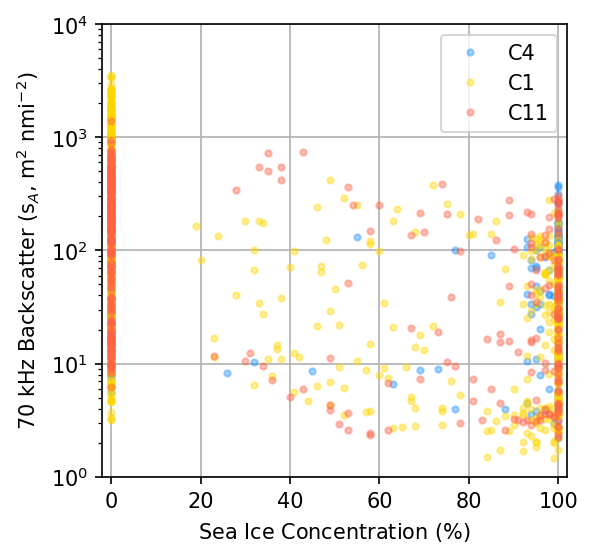

In [49]:
fig = plt.figure(figsize=(4,4),dpi=150)
df = dfD3
a = df['sA'].resample('2H').sum()
b = a.resample('D').mean()
df = dfD1Ice
a = df.resample('D').mean()
c = a.join(b)
plt.semilogy(c.iceC*100,c.sA,'.',color='dodgerblue',alpha=0.4)


df = dfD2
a = df['sA'].resample('2H').sum()
b = a.resample('D').mean()
df = dfD2Ice
a = df.resample('D').mean()
c = a.join(b)
plt.semilogy(c.iceC*100,(c.sA),'.',color='gold',alpha=0.4)


df = dfD1
a = df['sA'].resample('2H').sum()
b = a.resample('D').mean()
df = dfD3Ice
a = df.resample('D').mean()
c = a.join(b)
plt.semilogy(c.iceC*100,(c.sA),'.',color='tomato',alpha=0.4)

plt.axis([-2,102,0,10**4])
plt.grid()
plt.xlabel('Sea Ice Concentration ($\%$)')
plt.ylabel('70 kHz Backscatter (s$_{A}$, m$^{2}$ nmi$^{-2}$)')
plt.legend(['C4','C1','C11'],loc='upper right')

In [142]:
def bigFig(df,dfT,dfDayNight,dfIce, dfCtd,col):  
    plt.rcParams.update({'font.size':16})
    pltDict = {'D1':[0,0,5000],'D2':[0,0,5000],'D3':[1,0,2000]}
    f, [ax1,ax2,ax3,ax4] = plt.subplots(4,1,figsize=(20,16),sharex=True, sharey=True,dpi=150)
    
    ax1=plt.subplot(411)
    dfIce.iceC = dfIce.iceC/dfIce.iceC.max()
    dfIce.iceC.plot(legend=False,axes=ax1,color='grey',linewidth=2,label='Sea Ice')
    ax1_2 = dfCtd.Temp.plot(ax=ax1,secondary_y=True,color='skyblue',linewidth=2, label = 'Temperature')
    if pltDict[df.name][0]==1:
        ax1.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-100, ymax=100, alpha=0.3, color='grey')
    ax1.set_ylim([0,1])
    ax1.set_xlim([pd.to_datetime('2017-8-4'),pd.to_datetime('2019-9-4')])
    ax1.grid()
    ax1.set_ylabel('Sea Ice\nCover (%)')
    ax1_2.set_ylabel('Temperature ($^{o}$C)')
    legend_elements = [Line2D([0], [0], color='grey', lw=4, label='Sea Ice'),Line2D([0], [0], color='skyblue', lw=4, label='Temperature')]
    ax1.legend(handles=legend_elements,loc='lower left')
    plt.subplots_adjust(hspace=.2)

    ax2=plt.subplot(412)
    a = df['sA'].resample('2H').sum()
    a.plot( style='.',label='Wakeups',legend=False,axes=ax2, color=col)
    a.rolling('7D').mean().plot(legend=False,label='Running 7-Day Mean', axes=ax2,linewidth=2,color='k')
    if pltDict[df.name][0]==1:
        ax2.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-60, ymax=3000, alpha=0.3, color='grey')
    ax2.set_ylim([-60,pltDict[df.name][2]])
    #ax1.set_yticks([0,1000,2000,3000])
    ax2.set_xlim([pd.to_datetime('2017-8-4'),pd.to_datetime('2019-9-4')])
    ax2.grid()
    ax2.legend(['Wakeup Mean','Running 7-Day Mean'])#,loc = 'lower left')
    ax2.set_xticklabels([])
    ax2.xaxis.label.set_visible(False)
    plt.ylabel('70 kHz Backscatter\n(s$_{A}$, m$^{2}$ nmi$^{-2}$)')
    
    ax3=plt.subplot(413)
    dfT['SigBS_mean'] = 10**(dfT.TS_mean/10)
    a = 10*np.log10(dfT.SigBS_mean.resample('H').mean())
    a.plot( style='.',label='Wakeups',legend=False,axes=ax3,color=col)
    a.rolling('7D').mean().plot(legend=False,label='Daily Mean', axes=ax3,linewidth=2,color='k')
    if pltDict[df.name][0]==1:
        ax3.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-100, ymax=100, alpha=0.3, color='grey')
    ax3.set_ylim([-70,-35])
    ax3.set_xlim([pd.to_datetime('2017-8-4'),pd.to_datetime('2019-9-4')])
    ax3.grid()
    ax3.set_xticklabels([])
    ax3.xaxis.label.set_visible(False)
    plt.ylabel('70 kHz Target Strength\n(dB re 1 m$^{2}$)')
    plt.subplots_adjust(hspace=.2)
    
    ax4=plt.subplot(414)
    a = dfDayNight.night-dfDayNight.day
    ax4.plot(a.rolling('7D').mean(),'k')
    ax4.fill_between(a.rolling('7D').mean().index, a.rolling('7D').mean(), where=a.rolling('7D').mean()>=0, interpolate=True, color='red')
    ax4.fill_between(a.rolling('7D').mean().index, a.rolling('7D').mean(), where=a.rolling('7D').mean()<=0, interpolate=True, color='blue')
    #plt.hlines(0,pd.to_datetime('2017-8-4'),pd.to_datetime('2019-9-4'),'k')
    if pltDict[df.name][0]==1:
        ax4.axvspan(pd.to_datetime('2017-8-01'), pd.to_datetime('2018-8-14'), ymin=-40, ymax=30, alpha=0.3, color='grey')
    ax4.set_ylim([-25,15])
    ax4.set_xlim([pd.to_datetime('2017-8-4'),pd.to_datetime('2019-9-4')])
    ax4.grid()
    ax4.legend(['Running 7-Day Mean'])#,loc = 'lower left')
    #ax4.set_xticklabels([])
    #ax4.xaxis.label.set_visible(False)
    plt.ylabel('Night - Day Weighted\nMean Depth (m)')
    maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,2))
    ax4.xaxis.set_major_locator(maj_loc)
    min_loc = mdates.MonthLocator()
    ax4.xaxis.set_minor_locator(min_loc)
    zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
    maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, show_offset=False)
    ax4.xaxis.set_major_formatter(maj_fmt)
    ax4.set_xlabel('Date')

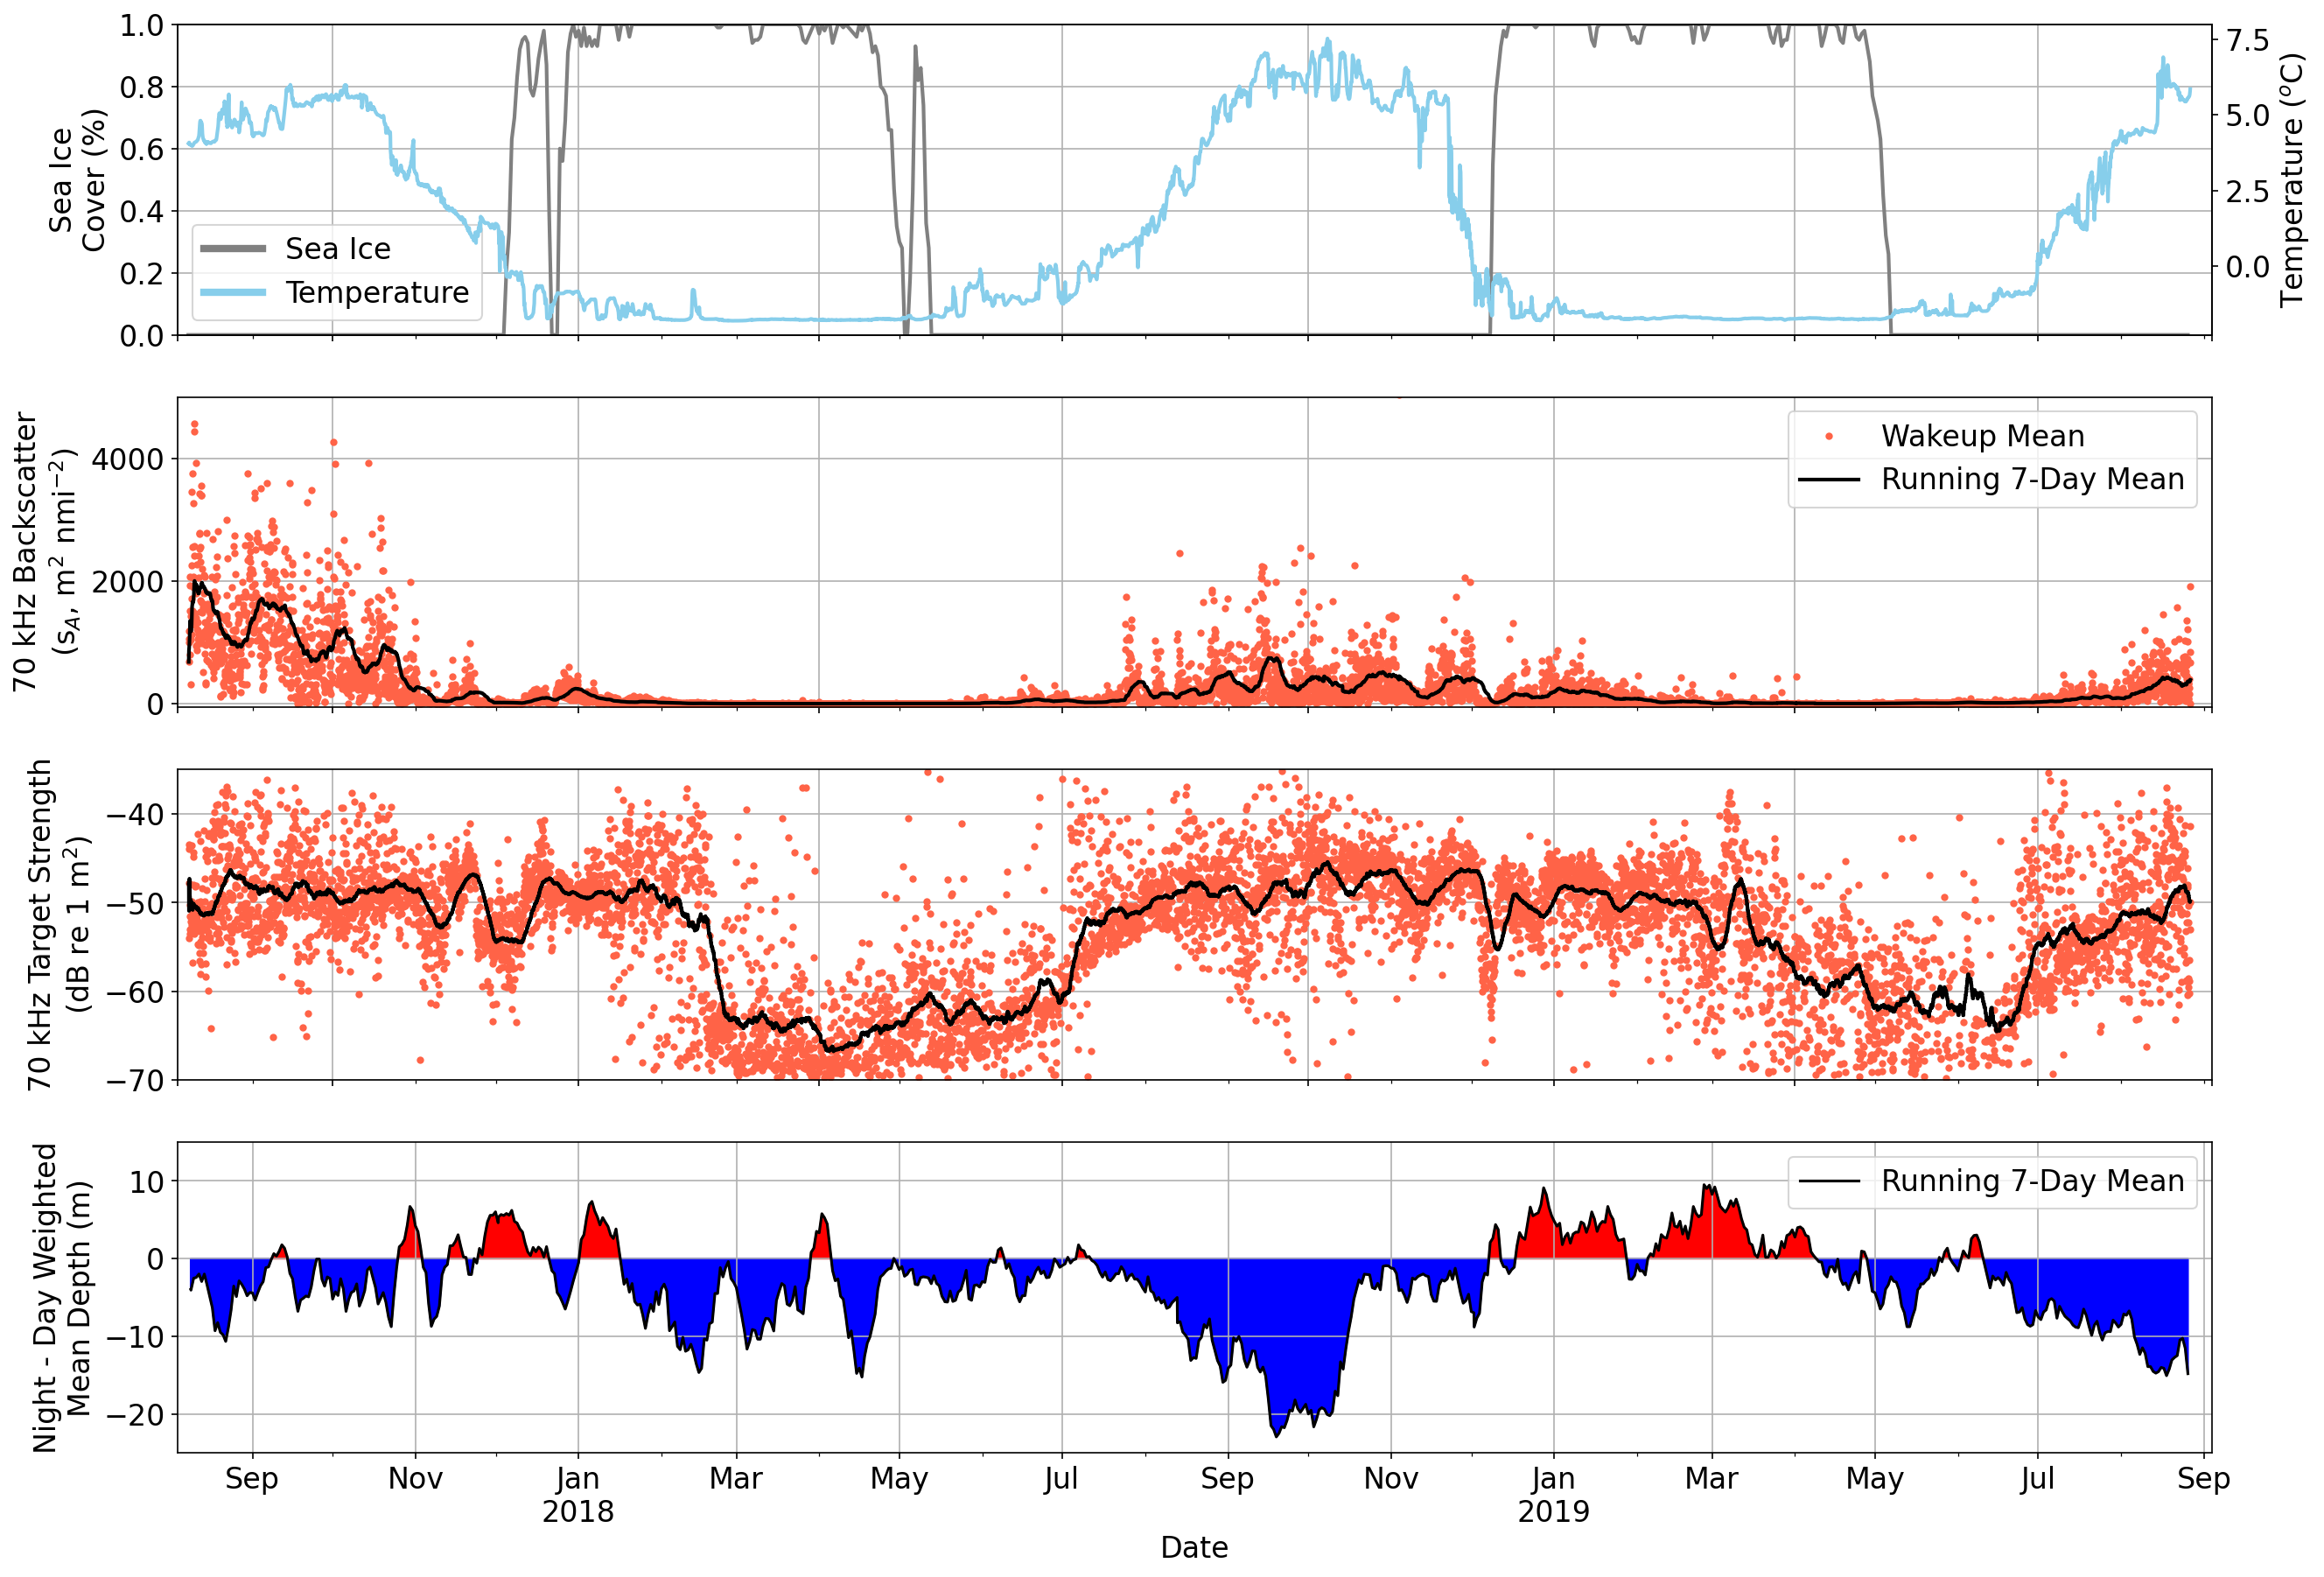

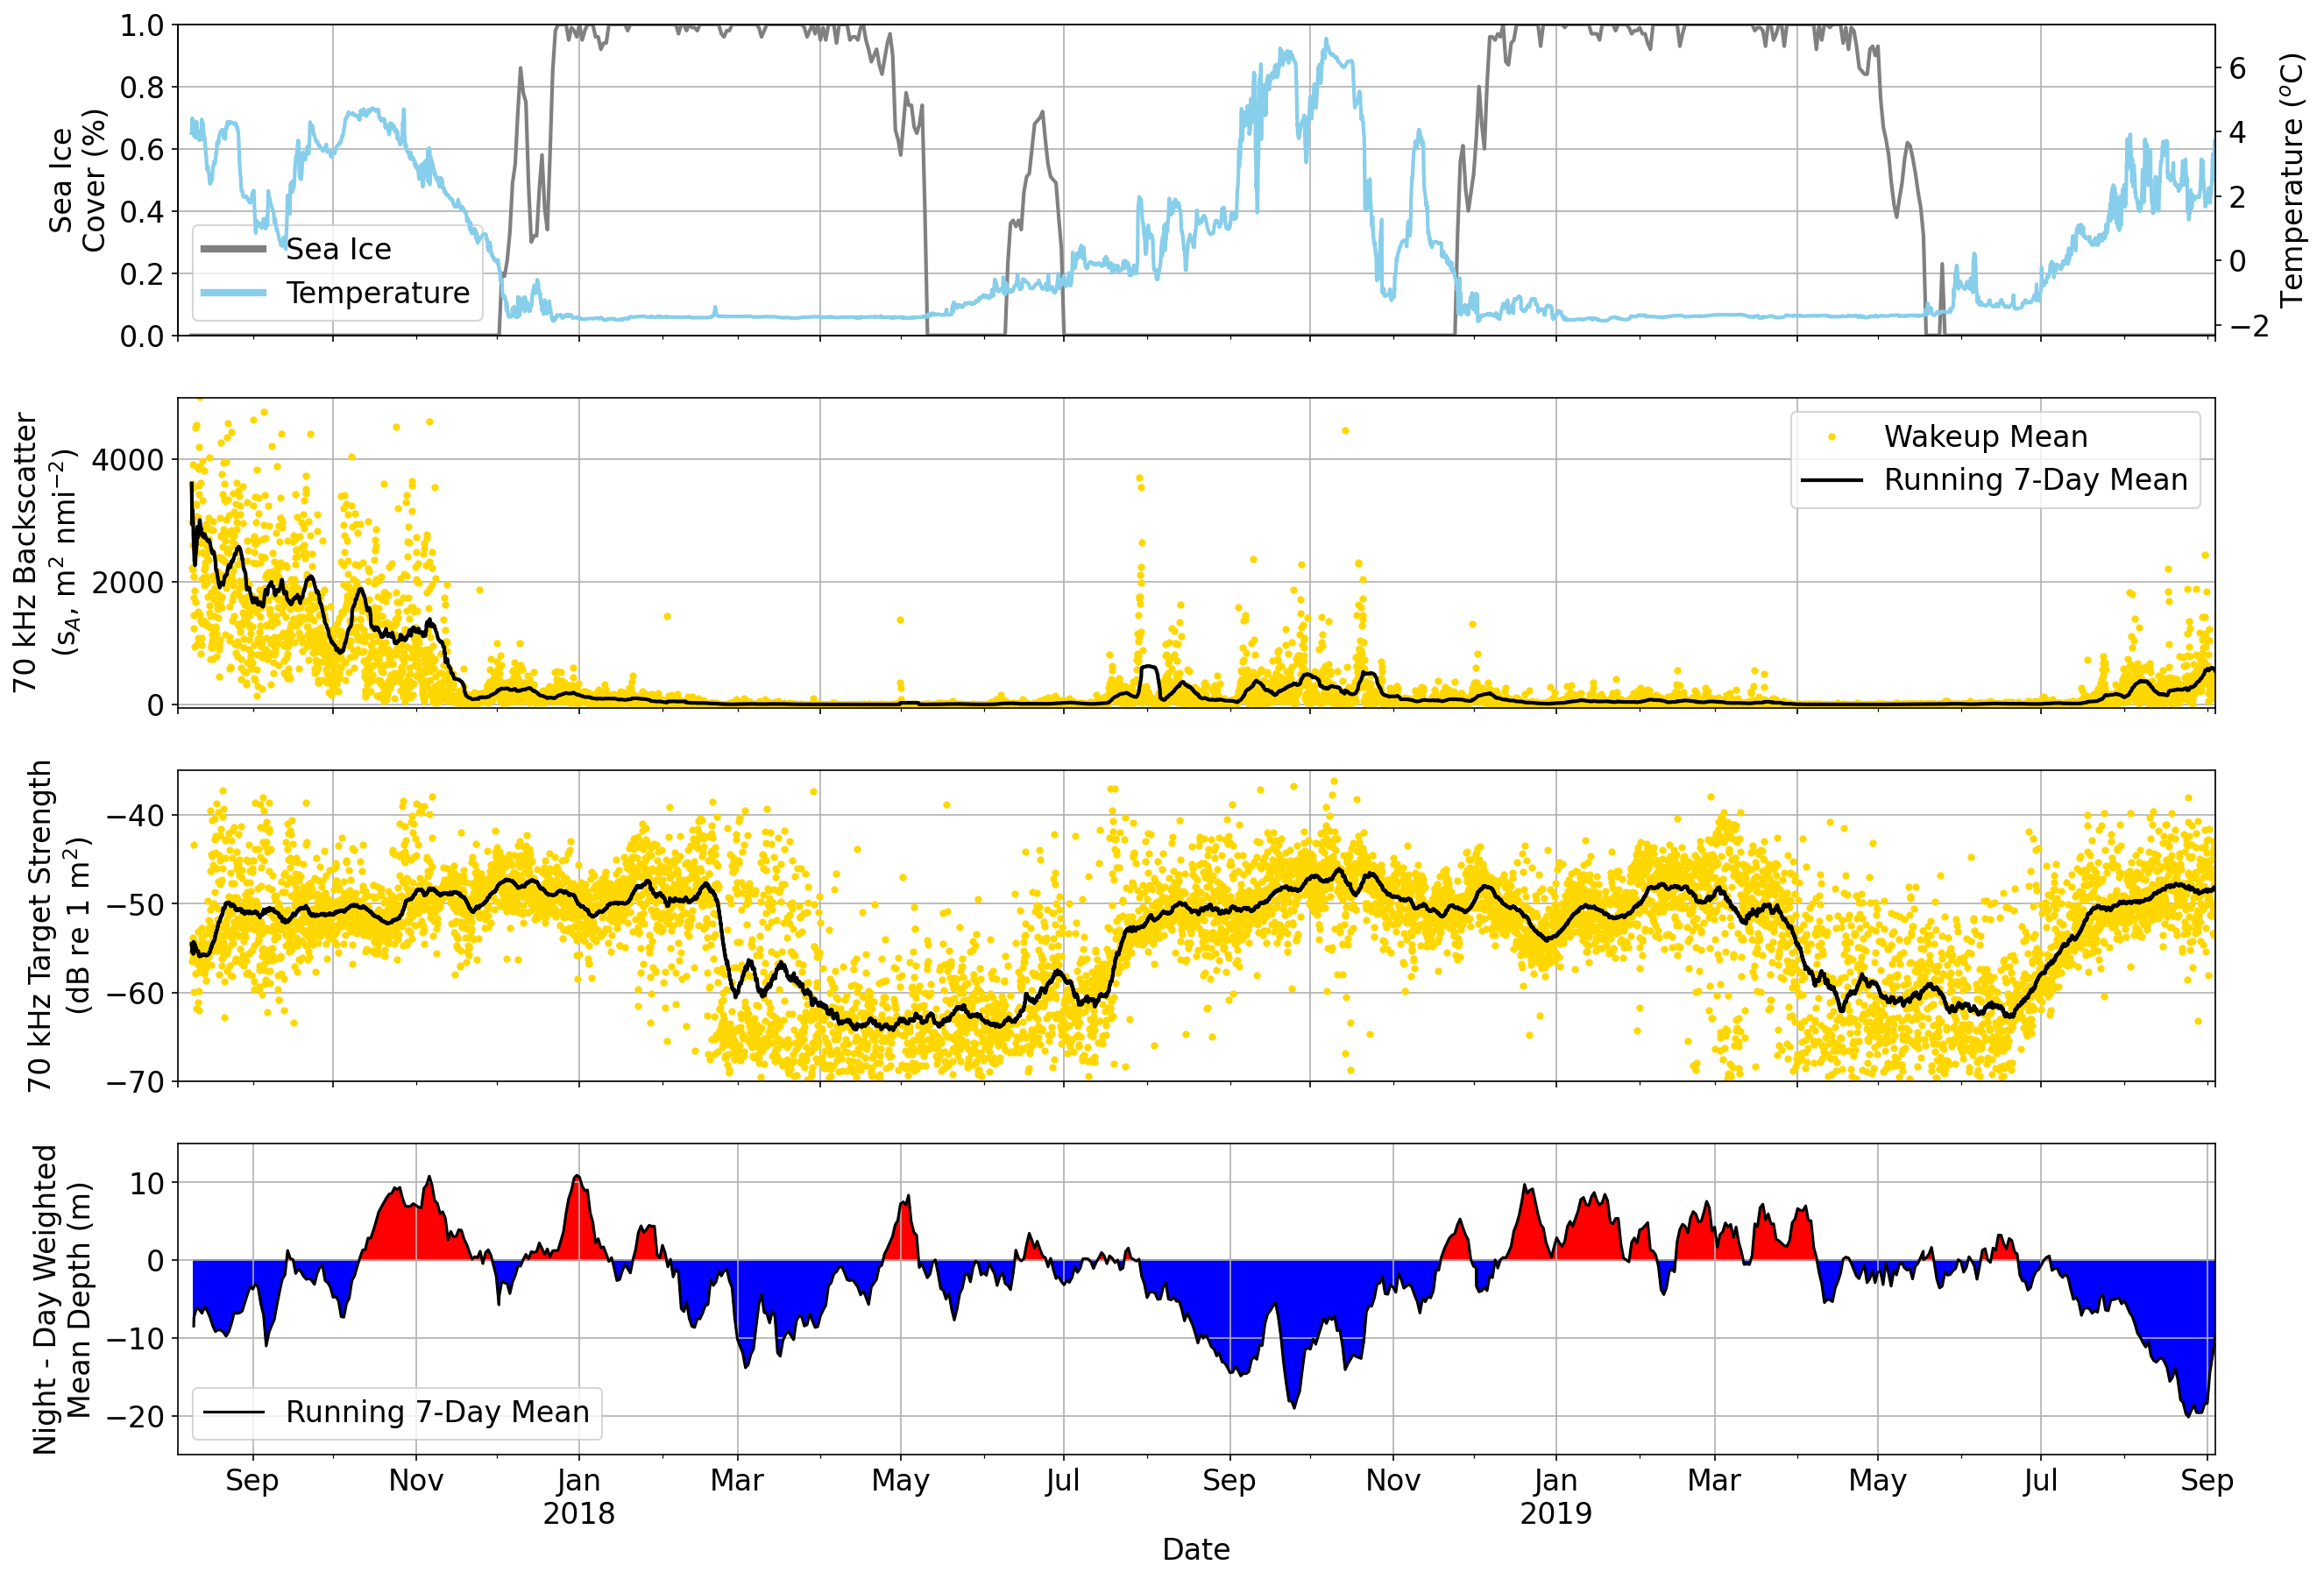

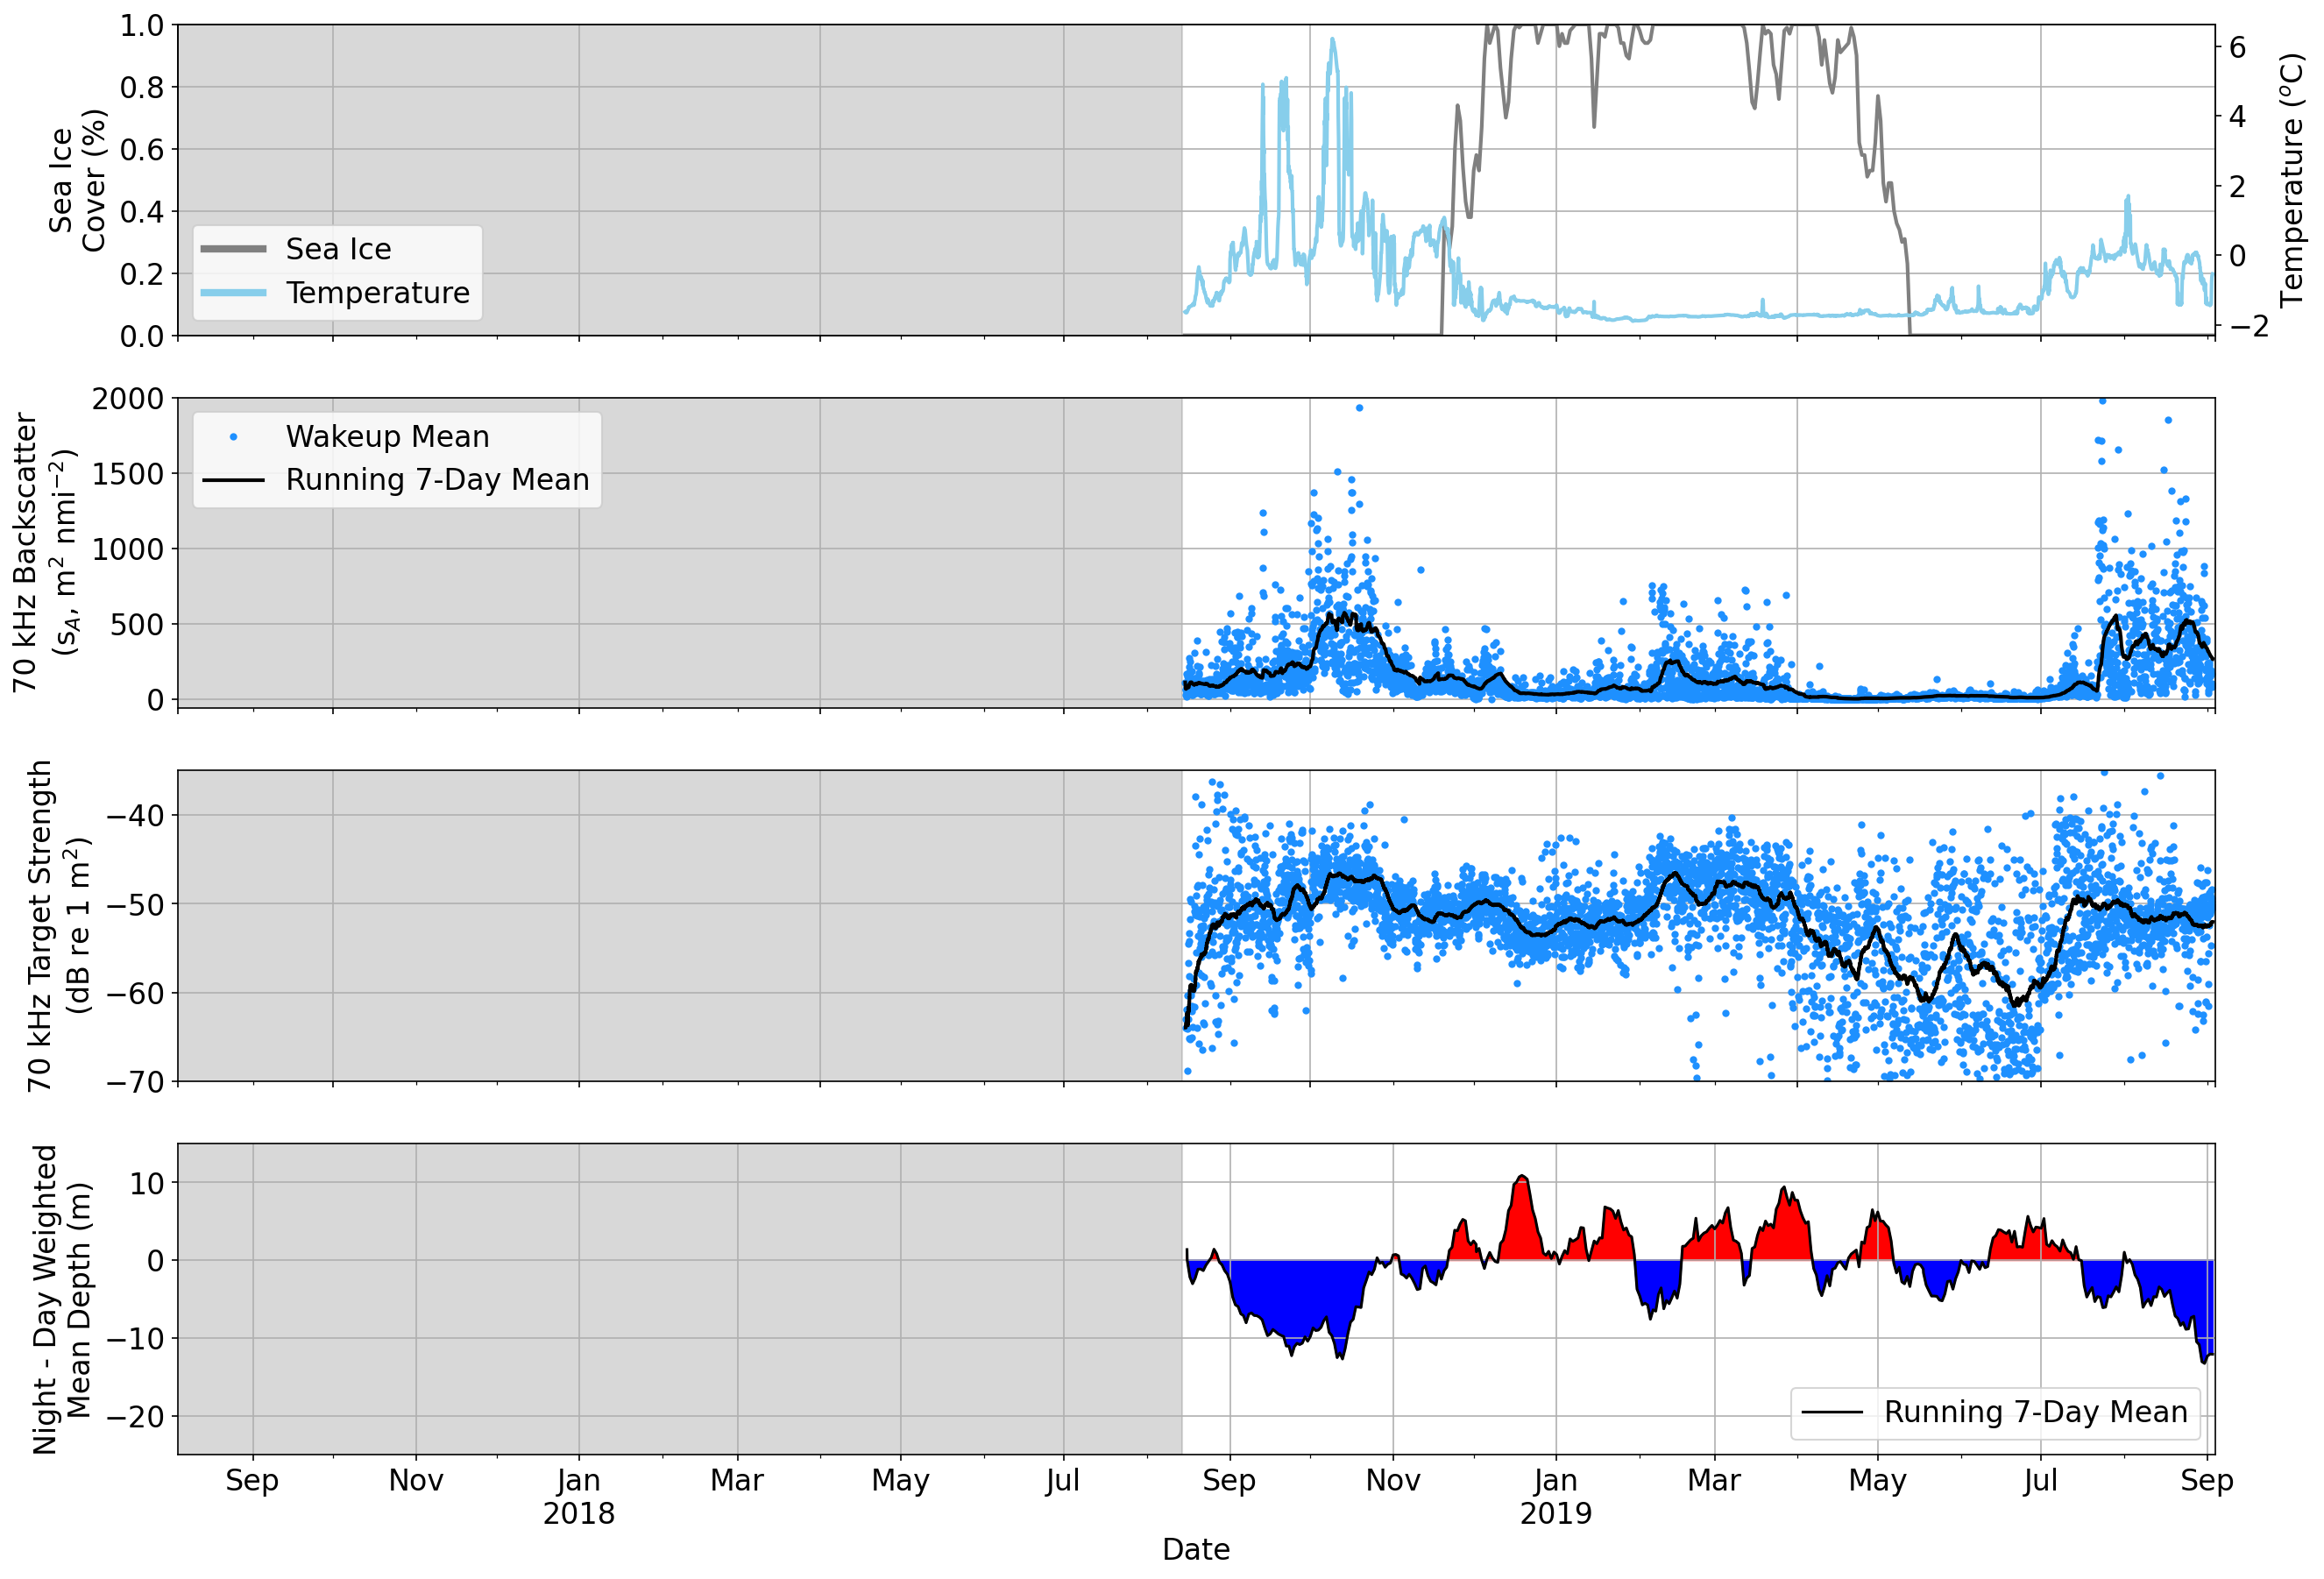

In [143]:
bigFig(dfD1,dfD1T,dfD1_DayNight,dfD1Ice,dfD1Ctd,'tomato')
bigFig(dfD2,dfD2T,dfD2_DayNight,dfD2Ice,dfD2Ctd,'gold')
bigFig(dfD3,dfD3T,dfD3_DayNight,dfD3Ice,dfD3Ctd,'dodgerblue')